# Method 2 - Rest Ideas After 10

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 10].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

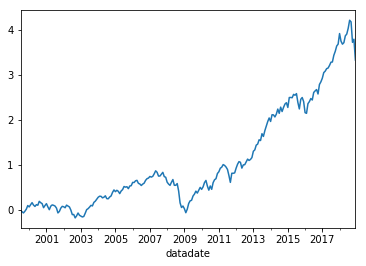

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.092987
2000-12-31    0.000709
2001-12-31   -0.016761
2002-12-31   -0.185150
2003-12-31    0.408695
2004-12-31    0.167041
2005-12-31    0.065464
2006-12-31    0.110750
2007-12-31    0.010823
2008-12-31   -0.371923
2009-12-31    0.383637
2010-12-31    0.206049
2011-12-31    0.007260
2012-12-31    0.187541
2013-12-31    0.407873
2014-12-31    0.111737
2015-12-31    0.007005
2016-12-31    0.129305
2017-12-31    0.218211
2018-12-31   -0.075613
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2660.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.31e-190
Time:                        23:38:30   Log-Likelihood:                 848.07
No. Observations:                 234   AIC:                            -1686.
Df Residuals:                     229   BIC:                            -1669.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.000      5.194      0.000       0.001       0.003
mktrf          0.9758      0.012     80.206      0.000       0.952       1.000
me             0.1974      0.014     13.951      0.000       0.170       0.225
ia             0.1248      0.022      5.804      0.000       0.082       0.167
roe            0.0152      0.018      0.823      0.411      -0.021       0.051
==============================================================================
Omnibus:                       17.879   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.233
Skew:                           0.156   Prob(JB):                     1.67e-12
Kurtosis:                       5.338   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1380.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.10e-159
Time:                        23:38:30   Log-Likelihood:                 848.07
No. Observations:                 234   AIC:                            -1686.
Df Residuals:                     229   BIC:                            -1669.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      4.589      0.000       0.001       0.003
mktrf          0.9758      0.017     58.368      0.000       0.943       1.009
me             0.1974      0.037      5.289      0.000       0.124       0.271
ia             0.1248      0.046      2.722      0.006       0.035       0.215
roe            0.0152      0.021      0.711      0.477      -0.027       0.057
==============================================================================
Omnibus:                       17.879   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.233
Skew:                           0.156   Prob(JB):                     1.67e-12
Kurtosis:                       5.338   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1489.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.34e-162
Time:                        23:38:30   Log-Likelihood:                 848.07
No. Observations:                 234   AIC:                            -1686.
Df Residuals:                     229   BIC:                            -1669.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.000      4.849      0.000       0.001       0.003
mktrf          0.9758      0.016     59.798      0.000       0.944       1.008
me             0.1974      0.036      5.539      0.000       0.128       0.267
ia             0.1248      0.053      2.339      0.019       0.020       0.229
roe            0.0152      0.023      0.664      0.507      -0.030       0.060
==============================================================================
Omnibus:                       17.879   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.233
Skew:                           0.156   Prob(JB):                     1.67e-12
Kurtosis:                       5.338   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2182.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.72e-190
Time:                        23:38:30   Log-Likelihood:                 851.44
No. Observations:                 234   AIC:                            -1691.
Df Residuals:                     228   BIC:                            -1670.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      4.302      0.000       0.001       0.003
mktrf          0.9900      0.012     82.211      0.000       0.966       1.014
smb            0.2302      0.016     14.487      0.000       0.199       0.262
hml            0.0325      0.019      1.735      0.084      -0.004       0.069
rmw            0.0597      0.021      2.819      0.005       0.018       0.101
cma            0.0734      0.027      2.725      0.007       0.020       0.126
==============================================================================
Omnibus:                       42.911   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.519
Skew:                           0.560   Prob(JB):                     2.15e-48
Kurtosis:                       7.611   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1224.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.72e-162
Time:                        23:38:30   Log-Likelihood:                 851.44
No. Observations:                 234   AIC:                            -1691.
Df Residuals:                     228   BIC:                            -1670.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      4.364      0.000       0.001       0.003
mktrf          0.9900      0.015     67.863      0.000       0.961       1.019
smb            0.2302      0.028      8.202      0.000       0.175       0.285
hml            0.0325      0.044      0.745      0.456      -0.053       0.118
rmw            0.0597      0.022      2.667      0.008       0.016       0.104
cma            0.0734      0.038      1.951      0.051      -0.000       0.147
==============================================================================
Omnibus:                       42.911   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.519
Skew:                           0.560   Prob(JB):                     2.15e-48
Kurtosis:                       7.611   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1655.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.16e-177
Time:                        23:38:30   Log-Likelihood:                 851.44
No. Observations:                 234   AIC:                            -1691.
Df Residuals:                     228   BIC:                            -1670.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      4.574      0.000       0.001       0.003
mktrf          0.9900      0.014     73.212      0.000       0.964       1.017
smb            0.2302      0.027      8.470      0.000       0.177       0.283
hml            0.0325      0.047      0.687      0.492      -0.060       0.125
rmw            0.0597      0.025      2.351      0.019       0.010       0.110
cma            0.0734      0.037      1.998      0.046       0.001       0.145
==============================================================================
Omnibus:                       42.911   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.519
Skew:                           0.560   Prob(JB):                     2.15e-48
Kurtosis:                       7.611   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2338.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.37e-184
Time:                        23:38:30   Log-Likelihood:                 833.35
No. Observations:                 234   AIC:                            -1657.
Df Residuals:                     229   BIC:                            -1639.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.000      5.426      0.000       0.002       0.003
mktrf          0.9633      0.012     80.751      0.000       0.940       0.987
smb            0.1986      0.015     13.338      0.000       0.169       0.228
hml            0.1208      0.015      8.169      0.000       0.092       0.150
umd           -0.0079      0.010     -0.816      0.416      -0.027       0.011
==============================================================================
Omnibus:                       41.193   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.814
Skew:                           0.587   Prob(JB):                     8.99e-40
Kurtosis:                       7.131   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1084.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.67e-147
Time:                        23:38:30   Log-Likelihood:                 833.35
No. Observations:                 234   AIC:                            -1657.
Df Residuals:                     229   BIC:                            -1639.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      4.245      0.000       0.001       0.004
mktrf          0.9633      0.018     53.527      0.000       0.928       0.999
smb            0.1986      0.031      6.400      0.000       0.138       0.259
hml            0.1208      0.050      2.400      0.016       0.022       0.220
umd           -0.0079      0.018     -0.443      0.658      -0.043       0.027
==============================================================================
Omnibus:                       41.193   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.814
Skew:                           0.587   Prob(JB):                     8.99e-40
Kurtosis:                       7.131   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1280.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.23e-155
Time:                        23:38:30   Log-Likelihood:                 833.35
No. Observations:                 234   AIC:                            -1657.
Df Residuals:                     229   BIC:                            -1639.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      4.135      0.000       0.001       0.004
mktrf          0.9633      0.017     57.049      0.000       0.930       0.996
smb            0.1986      0.032      6.186      0.000       0.136       0.262
hml            0.1208      0.058      2.070      0.038       0.006       0.235
umd           -0.0079      0.014     -0.559      0.576      -0.036       0.020
==============================================================================
Omnibus:                       41.193   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.814
Skew:                           0.587   Prob(JB):                     8.99e-40
Kurtosis:                       7.131   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1240.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.51e-93
Time:                        23:38:30   Log-Likelihood:                 420.34
No. Observations:                 120   AIC:                            -830.7
Df Residuals:                     115   BIC:                            -816.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.829      0.000       0.001       0.004
mktrf          0.9698      0.019     50.555      0.000       0.932       1.008
me             0.1742      0.019      9.194      0.000       0.137       0.212
ia             0.1886      0.030      6.357      0.000       0.130       0.247
roe           -0.0067      0.026     -0.256      0.798      -0.059       0.045
==============================================================================
Omnibus:                        5.782   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                7.235
Skew:                           0.238   Prob(JB):                       0.0268
Kurtosis:                       4.105   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     922.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.44e-86
Time:                        23:38:30   Log-Likelihood:                 420.34
No. Observations:                 120   AIC:                            -830.7
Df Residuals:                     115   BIC:                            -816.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.025      0.002       0.001       0.004
mktrf          0.9698      0.025     38.634      0.000       0.921       1.019
me             0.1742      0.039      4.440      0.000       0.097       0.251
ia             0.1886      0.041      4.588      0.000       0.108       0.269
roe           -0.0067      0.023     -0.288      0.774      -0.053       0.039
==============================================================================
Omnibus:                        5.782   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                7.235
Skew:                           0.238   Prob(JB):                       0.0268
Kurtosis:                       4.105   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1736.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.00e-102
Time:                        23:38:30   Log-Likelihood:                 420.34
No. Observations:                 120   AIC:                            -830.7
Df Residuals:                     115   BIC:                            -816.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.943      0.003       0.001       0.005
mktrf          0.9698      0.022     44.568      0.000       0.927       1.012
me             0.1742      0.039      4.498      0.000       0.098       0.250
ia             0.1886      0.042      4.488      0.000       0.106       0.271
roe           -0.0067      0.023     -0.293      0.770      -0.052       0.038
==============================================================================
Omnibus:                        5.782   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                7.235
Skew:                           0.238   Prob(JB):                       0.0268
Kurtosis:                       4.105   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     947.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.50e-91
Time:                        23:38:30   Log-Likelihood:                 418.16
No. Observations:                 120   AIC:                            -824.3
Df Residuals:                     114   BIC:                            -807.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.487      0.001       0.001       0.004
mktrf          1.0184      0.021     49.224      0.000       0.977       1.059
smb            0.2283      0.023      9.744      0.000       0.182       0.275
hml            0.0234      0.029      0.814      0.418      -0.034       0.080
rmw            0.0804      0.034      2.374      0.019       0.013       0.147
cma            0.1394      0.037      3.758      0.000       0.066       0.213
==============================================================================
Omnibus:                       29.573   Durbin-Watson:                   1.681
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.586
Skew:                           0.721   Prob(JB):                     1.08e-26
Kurtosis:                       7.673   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     871.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.82e-89
Time:                        23:38:30   Log-Likelihood:                 418.16
No. Observations:                 120   AIC:                            -824.3
Df Residuals:                     114   BIC:                            -807.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.214      0.001       0.001       0.004
mktrf          1.0184      0.024     42.138      0.000       0.971       1.066
smb            0.2283      0.039      5.807      0.000       0.151       0.305
hml            0.0234      0.069      0.340      0.734      -0.111       0.158
rmw            0.0804      0.041      1.946      0.052      -0.001       0.161
cma            0.1394      0.043      3.261      0.001       0.056       0.223
==============================================================================
Omnibus:                       29.573   Durbin-Watson:                   1.681
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.586
Skew:                           0.721   Prob(JB):                     1.08e-26
Kurtosis:                       7.673   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1467.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.13e-101
Time:                        23:38:30   Log-Likelihood:                 418.16
No. Observations:                 120   AIC:                            -824.3
Df Residuals:                     114   BIC:                            -807.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.326      0.001       0.001       0.004
mktrf          1.0184      0.021     49.591      0.000       0.978       1.059
smb            0.2283      0.039      5.855      0.000       0.152       0.305
hml            0.0234      0.075      0.313      0.754      -0.123       0.170
rmw            0.0804      0.046      1.767      0.077      -0.009       0.170
cma            0.1394      0.043      3.229      0.001       0.055       0.224
==============================================================================
Omnibus:                       29.573   Durbin-Watson:                   1.681
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.586
Skew:                           0.721   Prob(JB):                     1.08e-26
Kurtosis:                       7.673   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     967.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.67e-87
Time:                        23:38:30   Log-Likelihood:                 405.81
No. Observations:                 120   AIC:                            -801.6
Df Residuals:                     115   BIC:                            -787.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      4.452      0.000       0.002       0.005
mktrf          0.9575      0.019     50.195      0.000       0.920       0.995
smb            0.1999      0.022      9.203      0.000       0.157       0.243
hml            0.1542      0.022      7.090      0.000       0.111       0.197
umd           -0.0161      0.013     -1.198      0.233      -0.043       0.011
==============================================================================
Omnibus:                       22.560   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.057
Skew:                           0.551   Prob(JB):                     3.05e-17
Kurtosis:                       6.742   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     710.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.59e-80
Time:                        23:38:30   Log-Likelihood:                 405.81
No. Observations:                 120   AIC:                            -801.6
Df Residuals:                     115   BIC:                            -787.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      4.006      0.000       0.002       0.005
mktrf          0.9575      0.029     33.275      0.000       0.901       1.014
smb            0.1999      0.034      5.880      0.000       0.133       0.266
hml            0.1542      0.062      2.508      0.012       0.034       0.275
umd           -0.0161      0.019     -0.839      0.402      -0.054       0.021
==============================================================================
Omnibus:                       22.560   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.057
Skew:                           0.551   Prob(JB):                     3.05e-17
Kurtosis:                       6.742   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1122.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.16e-91
Time:                        23:38:30   Log-Likelihood:                 405.81
No. Observations:                 120   AIC:                            -801.6
Df Residuals:                     115   BIC:                            -787.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      4.023      0.000       0.002       0.005
mktrf          0.9575      0.023     41.547      0.000       0.912       1.003
smb            0.1999      0.036      5.518      0.000       0.129       0.271
hml            0.1542      0.067      2.289      0.022       0.022       0.286
umd           -0.0161      0.015     -1.098      0.272      -0.045       0.013
==============================================================================
Omnibus:                       22.560   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.057
Skew:                           0.551   Prob(JB):                     3.05e-17
Kurtosis:                       6.742   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2546.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.25e-106
Time:                        23:38:30   Log-Likelihood:                 466.36
No. Observations:                 114   AIC:                            -922.7
Df Residuals:                     109   BIC:                            -909.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.000      4.808      0.000       0.001       0.003
mktrf          0.9805      0.012     80.585      0.000       0.956       1.005
me             0.2493      0.019     13.270      0.000       0.212       0.287
ia            -0.0652      0.026     -2.501      0.014      -0.117      -0.014
roe           -0.0098      0.023     -0.426      0.671      -0.055       0.036
==============================================================================
Omnibus:                        2.978   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.226   Jarque-Bera (JB):                2.379
Skew:                          -0.293   Prob(JB):                        0.304
Kurtosis:                       3.396   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2747.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.05e-108
Time:                        23:38:30   Log-Likelihood:                 466.36
No. Observations:                 114   AIC:                            -922.7
Df Residuals:                     109   BIC:                            -909.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.000      4.813      0.000       0.001       0.003
mktrf          0.9805      0.010     94.073      0.000       0.960       1.001
me             0.2493      0.018     13.760      0.000       0.214       0.285
ia            -0.0652      0.030     -2.154      0.031      -0.124      -0.006
roe           -0.0098      0.024     -0.414      0.679      -0.056       0.036
==============================================================================
Omnibus:                        2.978   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.226   Jarque-Bera (JB):                2.379
Skew:                          -0.293   Prob(JB):                        0.304
Kurtosis:                       3.396   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     3551.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.97e-114
Time:                        23:38:30   Log-Likelihood:                 466.36
No. Observations:                 114   AIC:                            -922.7
Df Residuals:                     109   BIC:                            -909.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.000      4.681      0.000       0.001       0.003
mktrf          0.9805      0.010     98.792      0.000       0.961       1.000
me             0.2493      0.020     12.711      0.000       0.211       0.288
ia            -0.0652      0.035     -1.872      0.061      -0.133       0.003
roe           -0.0098      0.021     -0.467      0.641      -0.051       0.031
==============================================================================
Omnibus:                        2.978   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.226   Jarque-Bera (JB):                2.379
Skew:                          -0.293   Prob(JB):                        0.304
Kurtosis:                       3.396   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     4088.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.51e-121
Time:                        23:38:30   Log-Likelihood:                 506.30
No. Observations:                 114   AIC:                            -1001.
Df Residuals:                     108   BIC:                            -984.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      4.328      0.000       0.001       0.002
mktrf          0.9805      0.008    119.399      0.000       0.964       0.997
smb            0.2176      0.013     16.325      0.000       0.191       0.244
hml            0.0008      0.017      0.045      0.964      -0.033       0.034
rmw           -0.0923      0.021     -4.432      0.000      -0.134      -0.051
cma           -0.0895      0.026     -3.385      0.001      -0.142      -0.037
==============================================================================
Omnibus:                        3.260   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.196   Jarque-Bera (JB):                2.651
Skew:                          -0.314   Prob(JB):                        0.266
Kurtosis:                       3.404   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     3978.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.09e-120
Time:                        23:38:30   Log-Likelihood:                 506.30
No. Observations:                 114   AIC:                            -1001.
Df Residuals:                     108   BIC:                            -984.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      3.972      0.000       0.001       0.002
mktrf          0.9805      0.008    119.981      0.000       0.964       0.997
smb            0.2176      0.011     19.111      0.000       0.195       0.240
hml            0.0008      0.013      0.058      0.954      -0.025       0.027
rmw           -0.0923      0.019     -4.915      0.000      -0.129      -0.055
cma           -0.0895      0.026     -3.389      0.001      -0.141      -0.038
==============================================================================
Omnibus:                        3.260   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.196   Jarque-Bera (JB):                2.651
Skew:                          -0.314   Prob(JB):                        0.266
Kurtosis:                       3.404   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     5228.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.58e-127
Time:                        23:38:30   Log-Likelihood:                 506.30
No. Observations:                 114   AIC:                            -1001.
Df Residuals:                     108   BIC:                            -984.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      3.766      0.000       0.001       0.002
mktrf          0.9805      0.007    137.090      0.000       0.966       0.995
smb            0.2176      0.010     21.275      0.000       0.198       0.238
hml            0.0008      0.009      0.081      0.935      -0.018       0.019
rmw           -0.0923      0.018     -5.088      0.000      -0.128      -0.057
cma           -0.0895      0.025     -3.510      0.000      -0.139      -0.040
==============================================================================
Omnibus:                        3.260   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.196   Jarque-Bera (JB):                2.651
Skew:                          -0.314   Prob(JB):                        0.266
Kurtosis:                       3.404   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     3770.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.72e-116
Time:                        23:38:30   Log-Likelihood:                 488.55
No. Observations:                 114   AIC:                            -967.1
Df Residuals:                     109   BIC:                            -953.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.767      0.007       0.000       0.002
mktrf          0.9909      0.009    104.407      0.000       0.972       1.010
smb            0.2380      0.015     16.085      0.000       0.209       0.267
hml           -0.0047      0.015     -0.307      0.760      -0.035       0.026
umd           -0.0009      0.011     -0.076      0.940      -0.024       0.022
==============================================================================
Omnibus:                        7.174   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                6.789
Skew:                          -0.511   Prob(JB):                       0.0336
Kurtosis:                       3.620   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1899.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.84e-100
Time:                        23:38:30   Log-Likelihood:                 488.55
No. Observations:                 114   AIC:                            -967.1
Df Residuals:                     109   BIC:                            -953.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.428      0.015       0.000       0.002
mktrf          0.9909      0.012     85.664      0.000       0.968       1.014
smb            0.2380      0.013     18.412      0.000       0.213       0.263
hml           -0.0047      0.013     -0.371      0.711      -0.029       0.020
umd           -0.0009      0.010     -0.088      0.930      -0.020       0.019
==============================================================================
Omnibus:                        7.174   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                6.789
Skew:                          -0.511   Prob(JB):                       0.0336
Kurtosis:                       3.620   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     2042.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.80e-101
Time:                        23:38:30   Log-Likelihood:                 488.55
No. Observations:                 114   AIC:                            -967.1
Df Residuals:                     109   BIC:                            -953.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.495      0.013       0.000       0.002
mktrf          0.9909      0.011     86.770      0.000       0.969       1.013
smb            0.2380      0.011     20.995      0.000       0.216       0.260
hml           -0.0047      0.010     -0.454      0.650      -0.025       0.015
umd           -0.0009      0.010     -0.086      0.931      -0.021       0.019
==============================================================================
Omnibus:                        7.174   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                6.789
Skew:                          -0.511   Prob(JB):                       0.0336
Kurtosis:                       3.620   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""